<a href="https://colab.research.google.com/github/ccardoso32/MVP-Machine-Learning-Analytics/blob/main/MVP_ML_%26_Analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/ccardoso32/MVP-Machine-Learning-Analytics/blob/main/MVP_ML_&_Analytics.ipynb" target="_blank">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# MVP: *Machine Learning & Analytics* ‚Äî Breast Cancer (Classifica√ß√£o)

**Autor:** CAIO CARDOSO DE SOUZA  
**Data:** 15/09/2025  
**Matr√≠cula:** 4052025000946  
**Dataset:** [Breast Cancer Wisconsin (Diagnostic) ‚Äî scikit-learn](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-dataset)



## 1. Escopo, objetivo e defini√ß√£o do problema

**Contexto:** O c√¢ncer de mama √© uma das principais causas de mortalidade entre mulheres. A detec√ß√£o precoce aumenta a chance de tratamento eficaz e reduz custos.  
**Objetivo:** Construir e comparar modelos de *machine learning* para classificar tumores como **malignos (0)** ou **benignos (1)** a partir de 30 vari√°veis num√©ricas extra√≠das de imagens histopatol√≥gicas.  
**Tipo de tarefa:** Classifica√ß√£o bin√°ria supervisionada.  
**√Årea:** Dados tabulares biom√©dicos.  
**Valor de neg√≥cio/usu√°rio:** Apoio √† decis√£o cl√≠nica (triagem).


## 2. Reprodutibilidade e ambiente

In [1]:

# === Bloco 2: Setup b√°sico e reprodutibilidade ===
import warnings; warnings.filterwarnings("ignore")

import sys, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# sklearn core
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score,
                                     GridSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier)

# m√©tricas/plots
from sklearn.metrics import (accuracy_score, f1_score, roc_auc_score, classification_report,
                             ConfusionMatrixDisplay)

# reprodutibilidade
SEED = 42
np.random.seed(SEED); random.seed(SEED)

# visualiza√ß√£o de dataframes sem quebra
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 2000)

print("Python:", sys.version.split()[0], "| Seed:", SEED)


Python: 3.12.11 | Seed: 42


### 2.2 Fun√ß√µes auxiliares

In [2]:

def evaluate_classification(y_true, y_pred, proba=None):
    # Retorna dicion√°rio com m√©tricas principais
    out = {
        "accuracy": accuracy_score(y_true, y_pred),
        "f1_weighted": f1_score(y_true, y_pred, average="weighted"),
        "roc_auc": roc_auc_score(y_true, proba[:,1]) if proba is not None else np.nan
    }
    return out

def summarize_cv(results_dict):
    # Imprime m√©dia e desvio dos scores de CV e retorna ranking
    lines = []
    for name, scores in results_dict.items():
        lines.append((name, scores.mean(), scores.std()))
    lines = sorted(lines, key=lambda t: t[1], reverse=True)
    for name, m, s in lines:
        print(f"{name}: {m:.3f} ({s:.3f})")
    return lines



## 3. Dados: carga, entendimento e qualidade

**Fonte:** *scikit-learn* (`load_breast_cancer`). 569 inst√¢ncias, 30 vari√°veis num√©ricas.  
**√âtica/licen√ßa:** dataset p√∫blico; sem dados pessoais identific√°veis. Uso educacional.  
**Preven√ß√£o de *data leakage*:** divis√£o treino/teste **antes** de qualquer transforma√ß√£o; todas as transforma√ß√µes ajustadas **apenas no treino** via `Pipeline/ColumnTransformer`.


In [3]:

# === Bloco 3: Carga e entendimento dos dados ===
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name="target")

df = pd.concat([X, y], axis=1)
print("Formato (linhas, colunas):", df.shape)
print("Distribui√ß√£o de classes {maligno, benigno}:", dict(zip(data.target_names, np.bincount(data.target))))
df.head(10)


Formato (linhas, colunas): (569, 31)
Distribui√ß√£o de classes {maligno, benigno}: {np.str_('malignant'): np.int64(212), np.str_('benign'): np.int64(357)}


mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error  worst radius  worst texture  worst perimeter  worst area  worst smoothness  worst compactness  worst concavity  worst concave points  worst symmetry  worst fractal dimension  target
0        17.99         10.38          122.80     1001.0          0.11840           0.27760         0.30010              0.14710         0.2419                 0.07871        1.0950         0.9053            8.589      153.40          0.006399            0.04904          0.05373               0.01587         0.03003                 0.006193         25.38          17.33           184.60      2019.0            0.1622             0.6656           0.7119                0.2654          0.4601                  0.11890       0
1        20.57         17.77          132.90     1326.0          0.08474           0.07864         0.08690              0.07017         0.1812                 0.05667        0.5435         0.7339            3.398       74.08          0.005225            0.01308          0.01860               0.01340         0.01389                 0.003532         24.99          23.41           158.80      1956.0            0.1238             0.1866           0.2416                0.1860          0.2750                  0.08902       0
2        19.69         21.25          130.00     1203.0          0.10960           0.15990         0.19740              0.12790         0.2069                 0.05999        0.7456         0.7869            4.585       94.03          0.006150            0.04006          0.03832               0.02058         0.02250                 0.004571         23.57          25.53           152.50      1709.0            0.1444             0.4245           0.4504                0.2430          0.3613                  0.08758       0
3        11.42         20.38           77.58      386.1          0.14250           0.28390         0.24140              0.10520         0.2597                 0.09744        0.4956         1.1560            3.445       27.23          0.009110            0.07458          0.05661               0.01867         0.05963                 0.009208         14.91          26.50            98.87       567.7            0.2098             0.8663           0.6869                0.2575          0.6638                  0.17300       0
4        20.29         14.34          135.10     1297.0          0.10030           0.13280         0.19800              0.10430         0.1809                 0.05883        0.7572         0.7813            5.438       94.44          0.011490            0.02461          0.05688               0.01885         0.01756                 0.005115         22.54          16.67           152.20      1575.0            0.1374             0.2050           0.4000                0.1625          0.2364                  0.07678       0
5        12.45         15.70           82.57      477.1          0.12780           0.17000         0.15780              0.08089         0.2087                 0.07613        0.3345         0.8902            2.217       27.19          0.007510            0.03345          0.03672               0.01137         0.02165                 0.005082         15.47          23.75           103.40       741.6            0.1791             0.5249           0.5355                0.1741          0.3985                  0.12440       0
6        18.25         19.98          119.60     1040.0          0.09463           0.10900         0.11270              0.07400         0.1794                 0.05742        0.4467         0.7732            3.180       53.91          0.004314            0.01382          0.02254               0.01039         0.01369            

### 3.1 An√°lise explorat√≥ria resumida (EDA)

m√©dia  desvio_padr√£o     m√≠nimo     m√°ximo
mean radius       14.127292       3.524049    6.98100    28.1100
mean texture      19.289649       4.301036    9.71000    39.2800
mean perimeter    91.969033      24.298981   43.79000   188.5000
mean area        654.889104     351.914129  143.50000  2501.0000
mean smoothness    0.096360       0.014064    0.05263     0.1634

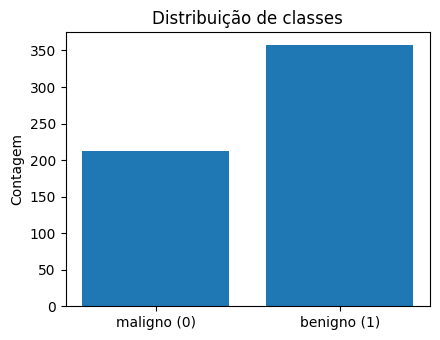

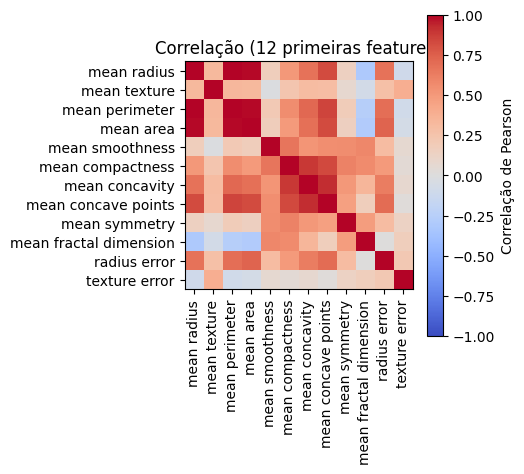

Pares com |correla√ß√£o| ‚â• 0.9 :
  - mean radius √ó mean perimeter: 0.998
  - mean radius √ó mean area: 0.987
  - mean perimeter √ó mean area: 0.987
  - mean concavity √ó mean concave points: 0.921


In [4]:
# === 3.1 An√°lise explorat√≥ria resumida (EDA) ===

# 1) Estat√≠sticas descritivas em portugu√™s
desc = (
    X.describe()
     .T[["mean", "std", "min", "max"]]
     .rename(columns={
         "mean": "m√©dia",
         "std": "desvio_padr√£o",
         "min": "m√≠nimo",
         "max": "m√°ximo"
     })
)
display(desc.head())

# 2) Distribui√ß√£o das classes (0 = maligno, 1 = benigno)
counts = np.unique(y, return_counts=True)
plt.figure(figsize=(4.5, 3.5))
plt.bar(["maligno (0)", "benigno (1)"], counts[1])
plt.title("Distribui√ß√£o de classes")
plt.ylabel("Contagem")
plt.tight_layout()
plt.show()

# 3) Correla√ß√£o (12 primeiras features) ‚Äî mapa de calor
cols = X.columns[:12]
corr = X[cols].corr(method="pearson")

plt.figure(figsize=(5.2, 5))
im = plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.colorbar(im, label="Correla√ß√£o de Pearson")
plt.xticks(range(len(cols)), cols, rotation=90)
plt.yticks(range(len(cols)), cols)
plt.title("Correla√ß√£o (12 primeiras features)")
plt.tight_layout()
plt.show()

# Sinalizar pares com alta correla√ß√£o para orientar sele√ß√£o de atributos
limiar = 0.90
pares_altamente_corr = []
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        val = corr.iloc[i, j]
        if abs(val) >= limiar:
            pares_altamente_corr.append((cols[i], cols[j], float(val)))

if pares_altamente_corr:
    print("Pares com |correla√ß√£o| ‚â•", limiar, ":")
    for a, b, v in sorted(pares_altamente_corr, key=lambda t: -abs(t[2])):
        print(f"  - {a} √ó {b}: {v:.3f}")
else:
    print("Nenhum par com correla√ß√£o muito alta (‚â•", limiar, ").")



## 4. Defini√ß√£o do target, vari√°veis e divis√£o dos dados

In [7]:

# === Bloco 4: Target e split 80/20 ===
target = "target"
features = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X[features], y, test_size=0.20, stratify=y, random_state=SEED
)
print("Train:", X_train.shape, "| Test:", X_test.shape)
print("Propor√ß√£o de classes (train):\n", y_train.value_counts(normalize=True).round(3))
print("Propor√ß√£o de classes (test):\n", y_test.value_counts(normalize=True).round(3))


Train: (455, 30) | Test: (114, 30)
Propor√ß√£o de classes (train):
 target
1    0.626
0    0.374
Name: proportion, dtype: float64
Propor√ß√£o de classes (test):
 target
1    0.632
0    0.368
Name: proportion, dtype: float64



## 5. Sele√ß√£o de vari√°veis (*Feature Selection*) ‚Äî opcional, orientada por import√¢ncia


**Crit√©rio adaptativo:**  
1) Ajustamos um **RandomForest** no treino com *imputa√ß√£o* para obter `feature_importances_`.  
2) Se a raz√£o `max_importance / min_importance < 3`, entendemos que os "pesos" s√£o relativamente parecidos ‚Üí **mantemos todas** as 30 vari√°veis (prefer√™ncia por interpretabilidade e simplicidade).  
3) Caso contr√°rio, mantemos o menor conjunto de vari√°veis que acumule **‚â•95%** da import√¢ncia total (com no m√≠nimo 12 features), e reportamos a lista final.  
4) Como checagem, tamb√©m calculamos o ranking univariado (`SelectKBest(f_classif)`) e mostramos a interse√ß√£o com as escolhidas.


> **Nota:** embora este dataset seja pequeno (569 amostras, 30 vari√°veis),
inclu√≠mos a etapa de *feature selection* **por fins educacionais**, para documentar o processo,
mostrar como evitar *data leakage* e observar o impacto na valida√ß√£o cruzada.


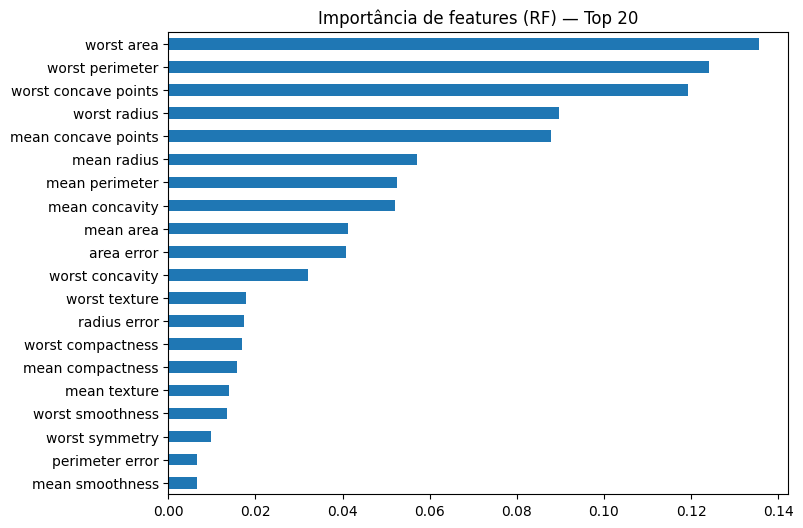

Raz√£o max/min de import√¢ncia: 34.65
Decis√£o: select_subset
N¬∫ de colunas finais: 20 / 30
Interse√ß√£o RF-Import√¢ncia vs SelectKBest: 19 colunas
['area error', 'mean area', 'mean compactness', 'mean concave points', 'mean concavity', 'mean perimeter', 'mean radius', 'mean texture', 'perimeter error', 'radius error'] ...


'Os pesos variaram bastante (max/min = 34.65). Mantivemos 20 vari√°veis que acumulam ‚â•95% da import√¢ncia (RF). Isso tende a reduzir vari√¢ncia e tempo de treino, com baixo custo de vi√©s.'

In [8]:

# === Bloco 5: Feature Selection ===
from sklearn.feature_selection import SelectKBest, f_classif

# 1) RF s√≥ com imputa√ß√£o
num_cols_all = X_train.columns.tolist()
rf_fs = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(n_estimators=400, random_state=SEED, n_jobs=-1))
])
rf_fs.fit(X_train[num_cols_all], y_train)
importances = rf_fs.named_steps["rf"].feature_importances_
imp_ser = pd.Series(importances, index=num_cols_all).sort_values(ascending=False)

# Plot top-20 para diagn√≥stico
ax = imp_ser.head(20).plot(kind="barh", figsize=(8,6))
plt.gca().invert_yaxis()
plt.title("Import√¢ncia de features (RF) ‚Äî Top 20")
plt.show()

ratio = imp_ser.max() / max(imp_ser.min(), 1e-12)
cum = imp_ser.cumsum()

# 2) Decis√£o adaptativa
if ratio < 3.0:
    decision = "keep_all"
    final_num_cols = num_cols_all  # pesos semelhantes ‚Üí manter todas
else:
    cutoff_idx = np.argmax(cum.values >= 0.95)  # menor √≠ndice que atinge 95%
    cutoff_idx = max(cutoff_idx, 11)            # garantir pelo menos 12 colunas
    final_num_cols = imp_ser.index[:cutoff_idx+1].tolist()
    decision = "select_subset"

print(f"Raz√£o max/min de import√¢ncia: {ratio:.2f}")
print(f"Decis√£o: {decision}")
print(f"N¬∫ de colunas finais: {len(final_num_cols)} / {len(num_cols_all)}")

# 3) Checagem com SelectKBest (mesmo tamanho do conjunto escolhido)
k_sel = len(final_num_cols)
skb = Pipeline([
    ("imp", SimpleImputer(strategy="median")),
    ("std", StandardScaler()),
    ("skb", SelectKBest(score_func=f_classif, k=k_sel))
])
skb.fit(X_train[num_cols_all], y_train)
mask = skb.named_steps["skb"].get_support()
skb_cols = X_train.columns[mask].tolist()

inter = set(final_num_cols).intersection(skb_cols)
print(f"Interse√ß√£o RF-Import√¢ncia vs SelectKBest: {len(inter)} colunas")
print(sorted(list(inter))[:10], "...")

# Vamos registrar o racional em texto para o relat√≥rio
if decision == "keep_all":
    rationale_text = (
        "Os pesos relativos est√£o pr√≥ximos (max/min < 3). Mantivemos as 30 vari√°veis "
        "para preservar interpretabilidade e evitar risco de remover sinais √∫teis; "
        "models baseados em √°rvore e regress√£o log√≠stica lidam bem com esse tamanho."
    )
else:
    rationale_text = (
        f"Os pesos variaram bastante (max/min = {ratio:.2f}). Mantivemos "
        f"{len(final_num_cols)} vari√°veis que acumulam ‚â•95% da import√¢ncia (RF). "
        "Isso tende a reduzir vari√¢ncia e tempo de treino, com baixo custo de vi√©s."
    )

rationale_text



### 5.1 Efeito da *feature selection*: antes vs. depois (CV estratificada 10-fold)

Para fins **did√°ticos**, comparamos rapidamente 3 modelos (Regress√£o Log√≠stica, RandomForest, KNN)
**antes** (todas as 30 vari√°veis) e **depois** (conjunto `final_num_cols`) da sele√ß√£o,
sempre dentro de *pipelines* para evitar *leakage*. Reportamos m√©dia e desvio-padr√£o da **acur√°cia (CV=10)**
e o **delta** entre as vers√µes.


Compara√ß√£o (acur√°cia CV=10) ‚Äî antes vs. depois da FS


antes_mean  antes_std  depois_mean  depois_std  delta_mean
modelo                                                            
LogReg      0.9824     0.0133       0.9802      0.0182     -0.0022
RF          0.9628     0.0337       0.9627      0.0278     -0.0001
KNN         0.9671     0.0148       0.9758      0.0207      0.0087

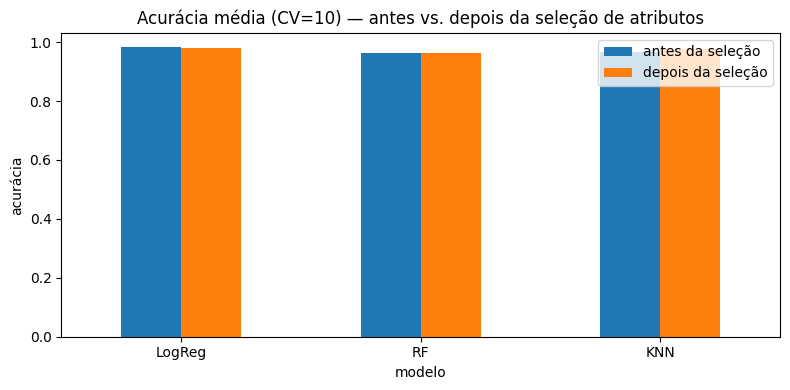

In [9]:

# === Bloco 5.1: Compara√ß√£o antes/depois da FS (CV=10) ===

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

# Pipelines "antes" (todas as colunas)
all_cols = X_train.columns.tolist()
pre_none_all = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), all_cols)])
pre_std_all  = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), all_cols)])

models_before = {
    "LogReg": Pipeline([("pre", pre_std_all),  ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF"    : Pipeline([("pre", pre_none_all), ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN"   : Pipeline([("pre", pre_std_all),  ("m", KNeighborsClassifier())])
}

# Pipelines "depois" (features finais)
pre_none_fs = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), final_num_cols)])
pre_std_fs  = ColumnTransformer([("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler())]), final_num_cols)])

models_after = {
    "LogReg": Pipeline([("pre", pre_std_fs),  ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF"    : Pipeline([("pre", pre_none_fs), ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN"   : Pipeline([("pre", pre_std_fs),  ("m", KNeighborsClassifier())])
}

rows = []
for name in ["LogReg", "RF", "KNN"]:
    sc_before = cross_val_score(models_before[name], X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    sc_after  = cross_val_score(models_after[name],  X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    rows.append({
        "modelo": name,
        "antes_mean": sc_before.mean(), "antes_std": sc_before.std(),
        "depois_mean": sc_after.mean(), "depois_std": sc_after.std(),
        "delta_mean": sc_after.mean() - sc_before.mean()
    })

cmp_df = pd.DataFrame(rows).set_index("modelo").round(4)
print("Compara√ß√£o (acur√°cia CV=10) ‚Äî antes vs. depois da FS")
display(cmp_df)

# --- Visualiza√ß√£o (portugu√™s) ---
ax = cmp_df[["antes_mean", "depois_mean"]].plot(kind="bar", figsize=(8,4))
ax.set_title("Acur√°cia m√©dia (CV=10) ‚Äî antes vs. depois da sele√ß√£o de atributos")
ax.set_ylabel("acur√°cia")
ax.set_xlabel("modelo")
plt.xticks(rotation=0)

# legenda mais clara
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, ["antes da sele√ß√£o", "depois da sele√ß√£o"], loc="best")
plt.tight_layout()
plt.show()


### 5.2 Compara√ß√£o de *Feature Selection* b√°sica vs. refinada (remo√ß√£o de vari√°veis altamente correlacionadas)

Ap√≥s avaliarmos a sele√ß√£o de vari√°veis baseada na import√¢ncia (Random Forest) e garantirmos um conjunto reduzido de colunas relevantes, fazemos um passo **refinado** para verificar poss√≠veis pares de vari√°veis ainda **altamente correlacionadas** (|r| ‚â• 0.90).  

**Racional do refinamento:**
1. Identificamos pares de vari√°veis muito correlacionadas no conjunto escolhido.
2. Para cada par, removemos a vari√°vel com **menor import√¢ncia relativa** segundo o ranking da Random Forest.
3. Assim, preservamos vari√°veis mais informativas e reduzimos redund√¢ncia no modelo.
4. Avaliamos novamente os tr√™s modelos (Regress√£o Log√≠stica, Floresta Aleat√≥ria e KNN), comparando:
   - **FS b√°sica** (todas as vari√°veis selecionadas pela estrat√©gia inicial).
   - **FS refinada** (mesmo conjunto, mas removendo colunas redundantes).

**Objetivo:** observar se a remo√ß√£o de redund√¢ncias melhora (ou mant√©m) a acur√°cia m√©dia em valida√ß√£o cruzada (CV=10), com menor custo de dimensionalidade.

> Em resumo: a FS refinada busca um equil√≠brio entre **simplicidade e desempenho**, garantindo que as vari√°veis escolhidas sejam ao mesmo tempo relevantes e n√£o redundantes.


Limiar de correla√ß√£o (|r|): 0.9
Pares encontrados (|r| >= 0.9): 21
 - mean radius √ó mean perimeter: 0.998
 - worst perimeter √ó worst radius: 0.993
 - mean radius √ó mean area: 0.989
 - mean perimeter √ó mean area: 0.988
 - worst area √ó worst radius: 0.986
 - worst area √ó worst perimeter: 0.979
 - worst perimeter √ó mean perimeter: 0.971
 - radius error √ó perimeter error: 0.971
 - worst radius √ó mean radius: 0.970
 - worst radius √ó mean perimeter: 0.970

Vari√°veis removidas na FS refinada por alta correla√ß√£o: ['mean area', 'mean concave points', 'mean concavity', 'mean perimeter', 'mean radius', 'mean texture', 'perimeter error', 'radius error', 'worst perimeter', 'worst radius']
Qtd colunas ‚Äî FS b√°sica: 20 | FS refinada: 10

Compara√ß√£o (acur√°cia CV=10) ‚Äî FS b√°sica vs. FS refinada


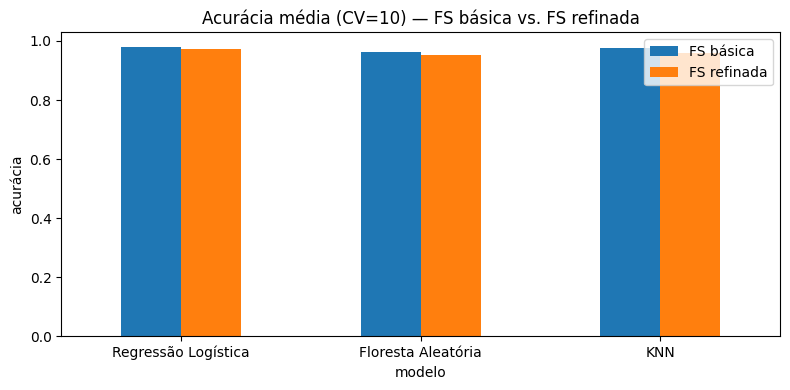


Feature selection refinada (remo√ß√£o de vari√°veis altamente correlacionadas) removeu 10 coluna(s) redundantes, resultando em 10 vari√°veis finais. Em m√©dia, observamos uma leve queda m√©dia de acur√°cia (Œî m√©dio = -0.0109). O melhor desempenho ap√≥s o refinamento foi com **Regress√£o Log√≠stica** (acur√°cia m√©dia=0.9737).


In [10]:
# === 5.2 FS b√°sica vs FS refinada (remo√ß√£o de redund√¢ncias por alta correla√ß√£o) ===

# --- 1) Encontrar pares ainda altamente correlacionados dentro de final_num_cols
thr = 0.90  # limiar did√°tico (|r| >= 0.90)
corr_mat = X_train[final_num_cols].corr(method="pearson").abs()

pares_alto_r = []
to_drop = set()

# examinamos somente o tri√¢ngulo superior para n√£o repetir pares
cols = final_num_cols
for i in range(len(cols)):
    for j in range(i + 1, len(cols)):
        r = corr_mat.loc[cols[i], cols[j]]
        if r >= thr:
            pares_alto_r.append((cols[i], cols[j], float(r)))

# --- 2) Escolher qual remover em cada par: fica a de MAIOR import√¢ncia; remove a de MENOR
for a, b, r in sorted(pares_alto_r, key=lambda t: -t[2]):  # come√ßa dos mais altos
    if a in to_drop or b in to_drop:
        continue  # j√° resolvido por outro par
    imp_a = float(imp_ser.get(a, 0.0))
    imp_b = float(imp_ser.get(b, 0.0))
    drop = a if imp_a < imp_b else b
    to_drop.add(drop)

refined_cols = [c for c in final_num_cols if c not in to_drop]

print(f"Limiar de correla√ß√£o (|r|): {thr}")
print(f"Pares encontrados (|r| >= {thr}): {len(pares_alto_r)}")
if pares_alto_r:
    for a, b, r in sorted(pares_alto_r, key=lambda t: -t[2])[:10]:
        print(f" - {a} √ó {b}: {r:.3f}")
print(f"\nVari√°veis removidas na FS refinada por alta correla√ß√£o: {sorted(list(to_drop))}")
print(f"Qtd colunas ‚Äî FS b√°sica: {len(final_num_cols)} | FS refinada: {len(refined_cols)}")

# --- 3) Preprocessadores equivalentes aos do 5.1 (para manter compara√ß√£o justa)
# LogReg / KNN: imputa√ß√£o + padroniza√ß√£o
pre_std_fs = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("sc", StandardScaler())]), final_num_cols)]
)
pre_std_refined = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median")),
                       ("sc", StandardScaler())]), refined_cols)]
)

# RF: somente imputa√ß√£o (sem StandardScaler), como no 5.1
pre_none_fs = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), final_num_cols)]
)
pre_none_refined = ColumnTransformer(
    [("num", Pipeline([("imp", SimpleImputer(strategy="median"))]), refined_cols)]
)

# --- 4) Modelos (mesmos do 5.1, com preprocessamento coerente)
modelos_basicos = {
    "LogReg": Pipeline([("pre", pre_std_fs),
                        ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF":     Pipeline([("pre", pre_none_fs),
                        ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN":    Pipeline([("pre", pre_std_fs),
                        ("m", KNeighborsClassifier())]),
}

modelos_refinados = {
    "LogReg": Pipeline([("pre", pre_std_refined),
                        ("m", LogisticRegression(max_iter=1000, random_state=SEED))]),
    "RF":     Pipeline([("pre", pre_none_refined),
                        ("m", RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1))]),
    "KNN":    Pipeline([("pre", pre_std_refined),
                        ("m", KNeighborsClassifier())]),
}

# --- 5) Avalia√ß√£o em CV=10 (acur√°cia)
rows = []
for nome in ["LogReg", "RF", "KNN"]:
    sc_b = cross_val_score(modelos_basicos[nome],  X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    sc_r = cross_val_score(modelos_refinados[nome], X_train, y_train, cv=cv10, scoring="accuracy", n_jobs=-1)
    rows.append({
        "modelo_en": nome,
        "antes_mean": sc_b.mean(), "antes_std": sc_b.std(),
        "refinada_mean": sc_r.mean(), "refinada_std": sc_r.std(),
        "delta_mean": sc_r.mean() - sc_b.mean()
    })

cmp_ref = pd.DataFrame(rows)

# Mapear nomes para PT-BR
nome_pt = {"LogReg": "Regress√£o Log√≠stica", "RF": "Floresta Aleat√≥ria", "KNN": "KNN"}
cmp_ref.insert(0, "modelo", cmp_ref["modelo_en"].map(nome_pt))
cmp_ref = cmp_ref.drop(columns=["modelo_en"])

print("\nCompara√ß√£o (acur√°cia CV=10) ‚Äî FS b√°sica vs. FS refinada")
display(cmp_ref.style.format({
    "antes_mean": "{:.4f}", "antes_std": "{:.4f}",
    "refinada_mean": "{:.4f}", "refinada_std": "{:.4f}",
    "delta_mean": "{:+.4f}"
}))

# --- 6) Gr√°fico em portugu√™s
ax = cmp_ref.set_index("modelo")[["antes_mean", "refinada_mean"]].plot(kind="bar", figsize=(8,4))
plt.title("Acur√°cia m√©dia (CV=10) ‚Äî FS b√°sica vs. FS refinada")
plt.ylabel("acur√°cia")
plt.xlabel("modelo")
plt.xticks(rotation=0)
plt.legend(["FS b√°sica", "FS refinada"])
plt.tight_layout()
plt.show()

# --- 7) Texto interpretativo autom√°tico (para o relat√≥rio)
melhor = cmp_ref.sort_values("refinada_mean", ascending=False).iloc[0]
delta_global = cmp_ref["delta_mean"].mean()

if abs(delta_global) < 0.005:
    efeito = "praticamente est√°vel"
elif delta_global > 0:
    efeito = "um ganho m√©dio de acur√°cia"
else:
    efeito = "uma leve queda m√©dia de acur√°cia"

rationale_fs_refinada = (
    "Feature selection refinada (remo√ß√£o de vari√°veis altamente correlacionadas) "
    f"removeu {len(to_drop)} coluna(s) redundantes, resultando em {len(refined_cols)} vari√°veis finais. "
    f"Em m√©dia, observamos {efeito} (Œî m√©dio = {delta_global:+.4f}). "
    f"O melhor desempenho ap√≥s o refinamento foi com **{melhor['modelo']}** "
    f"(acur√°cia m√©dia={melhor['refinada_mean']:.4f})."
)
print("\n" + rationale_fs_refinada)


## 6. Tratamento dos dados e Pipeline de pr√©-processamento

In [11]:

# === Bloco 6: Pr√©-processamento com as features finais (refined_cols) ===

num_cols = refined_cols  # usa a decis√£o do bloco 5

# Pipelines num√©ricos
numeric_pipe_none = Pipeline(steps=[
    ("imputar", SimpleImputer(strategy="median")),
])  # sem escala

numeric_pipe_std = Pipeline(steps=[
    ("imputar", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),
])

numeric_pipe_min = Pipeline(steps=[
    ("imputar", SimpleImputer(strategy="median")),
    ("scaler", MinMaxScaler()),
])

# ColumnTransformers (um por estrat√©gia)
preproc_none = ColumnTransformer([("num", numeric_pipe_none, num_cols)])
preproc_std  = ColumnTransformer([("num", numeric_pipe_std,  num_cols)])
preproc_min  = ColumnTransformer([("num", numeric_pipe_min,  num_cols)])

print(f"Colunas usadas nos pipelines: {len(num_cols)}")



Colunas usadas nos pipelines: 10


## 7. Baseline e modelos candidatos

In [12]:
# === Bloco 7: Defini√ß√£o dos modelos e montagem das pipelines ===
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

modelos = {
    "LR":  LogisticRegression(max_iter=1000, random_state=SEED),
    "KNN": KNeighborsClassifier(),
    "CART": DecisionTreeClassifier(random_state=SEED),
    "NB":  GaussianNB(),
    "SVM": SVC(probability=True, random_state=SEED),
    "Bag": BaggingClassifier(random_state=SEED),
    "RF":  RandomForestClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    "ET":  ExtraTreesClassifier(n_estimators=200, random_state=SEED, n_jobs=-1),
    "Ada": AdaBoostClassifier(random_state=SEED),
    "GB":  GradientBoostingClassifier(random_state=SEED),
}

voting = VotingClassifier(
    estimators=[("lr", modelos["LR"]), ("rf", modelos["RF"]), ("svm", modelos["SVM"])],
    voting="soft", n_jobs=-1
)

pipelines = {}

pipelines["Dummy"] = Pipeline([("pre", preproc_none),
                               ("modelo", DummyClassifier(strategy="most_frequent"))])

for tag_pre, pre in [("none", preproc_none), ("std", preproc_std), ("min", preproc_min)]:
    for nome, m in modelos.items():
        pipelines[f"{nome}-{tag_pre}"] = Pipeline([("pre", pre), ("modelo", m)])

for tag_pre, pre in [("none", preproc_none), ("std", preproc_std), ("min", preproc_min)]:
    pipelines[f"vot-{tag_pre}"] = Pipeline([("pre", pre), ("modelo", voting)])


### 7.1 Treino e avalia√ß√£o r√°pida (CV + boxplot)

Top 10 pipelines (m√©dia de acur√°cia em CV=10):


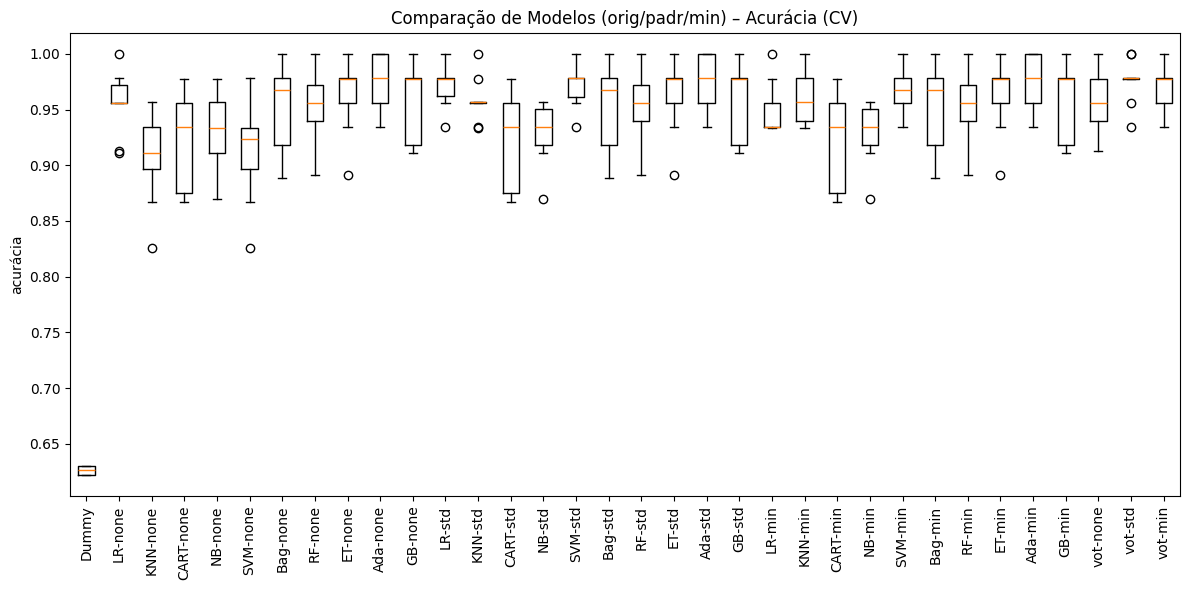

In [13]:
# === Bloco 7.1: Avalia√ß√£o r√°pida em CV (acur√°cia) e boxplot ===
cv_scores = {}
names, results = [], []

for name, pipe in pipelines.items():
    scores = cross_val_score(pipe, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)
    cv_scores[name] = scores
    names.append(name)
    results.append(scores)

def _resumo(scores_dict):
    rows = []
    for k, v in scores_dict.items():
        rows.append({"pipeline": k, "acc_mean": v.mean(), "acc_std": v.std()})
    return pd.DataFrame(rows).sort_values("acc_mean", ascending=False).reset_index(drop=True)

resumo_df = _resumo(cv_scores)
print("Top 10 pipelines (m√©dia de acur√°cia em CV=10):")
display(resumo_df.head(10).style.format({"acc_mean": "{:.4f}", "acc_std": "{:.4f}"}))

plt.figure(figsize=(12, 6))
plt.boxplot(results)
plt.xticks(rotation=90, ticks=range(1, len(names)+1), labels=names)
plt.title("Compara√ß√£o de Modelos (orig/padr/min) ‚Äì Acur√°cia (CV)")
plt.ylabel("acur√°cia")
plt.tight_layout()
plt.show()


## 8. Valida√ß√£o e Otimiza√ß√£o de Hiperpar√¢metros (GridSearch KNN)

In [14]:
# === Bloco 8: GridSearch do KNN em todos os pr√©-processamentos ===
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# grade (did√°tica) para KNN
param_grid_knn = {
    "modelo__n_neighbors": list(range(1, 23, 2)),              # 1,3,5,...,21
    "modelo__metric": ["euclidean", "manhattan", "minkowski"],
}

# dicion√°rio dos pr√©-processamentos que j√° existem no caderno
pre_dict = {
    "sem":          preproc_none,   # imputa√ß√£o apenas
    "padronizado":  preproc_std,    # imputa√ß√£o + StandardScaler
    "normalizado":  preproc_min,    # imputa√ß√£o + MinMaxScaler
}

melhor_global = {
    "pre_name": None,
    "best_score": -1.0,
    "gs": None,
}

print("# GridSearchCV para KNN")
for pre_name, pre in pre_dict.items():
    print(f"\n> Rodando KNN com pr√©-processamento: {pre_name}")
    pipe_knn = Pipeline([("pre", pre), ("modelo", KNeighborsClassifier())])
    gs = GridSearchCV(
        estimator=pipe_knn,
        param_grid=param_grid_knn,
        scoring="accuracy",
        cv=cv,
        n_jobs=-1,
        verbose=0,
    )
    gs.fit(X_train, y_train)
    print(f"  Melhores params (CV): {gs.best_params_}")
    print(f"  Melhor score (CV): {gs.best_score_:.4f}")

    if gs.best_score_ > melhor_global["best_score"]:
        melhor_global["best_score"] = gs.best_score_
        melhor_global["pre_name"]   = pre_name
        melhor_global["gs"]         = gs

# melhor KNN encontrado (com o melhor pr√©-processamento)
best_knn = melhor_global["gs"].best_estimator_
print("\n=== Resumo do melhor KNN ===")
print(f"Pr√©-processamento: {melhor_global['pre_name']}")
print(f"Melhor score (CV): {melhor_global['best_score']:.4f}")
print(f"Melhores par√¢metros: {melhor_global['gs'].best_params_}")

# üëâ incluir o KNN otimizado nos pipelines e nas m√©tricas de CV
pipelines["KNN_otimizado"] = best_knn
cv_scores["KNN_otimizado"] = cross_val_score(best_knn, X_train, y_train, cv=cv, scoring="accuracy", n_jobs=-1)

# (opcional) Tabelinha r√°pida comparando KNN base x KNN otimizado, se o base existir
if "KNN" in pipelines:
    base_mean = cv_scores["KNN"].mean()
    opt_mean  = cv_scores["KNN_otimizado"].mean()
    print("\nCompara√ß√£o r√°pida ‚Äî KNN (base) vs KNN (otimizado)")
    print(f"KNN (base)      ‚Äî m√©dia CV: {base_mean:.4f}")
    print(f"KNN (otimizado) ‚Äî m√©dia CV: {opt_mean:.4f}  | Œî = {opt_mean - base_mean:+.4f}")


# GridSearchCV para KNN

> Rodando KNN com pr√©-processamento: sem
  Melhores params (CV): {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 5}
  Melhor score (CV): 0.9253

> Rodando KNN com pr√©-processamento: padronizado
  Melhores params (CV): {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 13}
  Melhor score (CV): 0.9605

> Rodando KNN com pr√©-processamento: normalizado
  Melhores params (CV): {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 3}
  Melhor score (CV): 0.9605

=== Resumo do melhor KNN ===
Pr√©-processamento: padronizado
Melhor score (CV): 0.9605
Melhores par√¢metros: {'modelo__metric': 'manhattan', 'modelo__n_neighbors': 13}


## 9. Avalia√ß√£o final, an√°lise de erros e limita√ß√µes

Melhor pipeline por CV: Ada-none | m√©dia=0.9758

M√©tricas (teste):
              precision    recall  f1-score   support

     Maligno     0.9500    0.9048    0.9268        42
     Benigno     0.9459    0.9722    0.9589        72

    accuracy                         0.9474       114
   macro avg     0.9480    0.9385    0.9429       114
weighted avg     0.9474    0.9474    0.9471       114



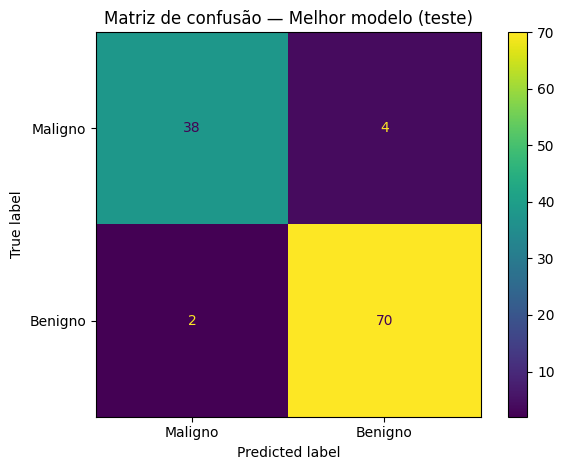


Top 15 import√¢ncias (dispon√≠vel):


worst area              0.239465
worst texture           0.178554
worst concave points    0.173510
area error              0.120470
mean compactness        0.085743
worst symmetry          0.059547
mean smoothness         0.056716
worst smoothness        0.051913
worst concavity         0.023763
worst compactness       0.010319
dtype: float64

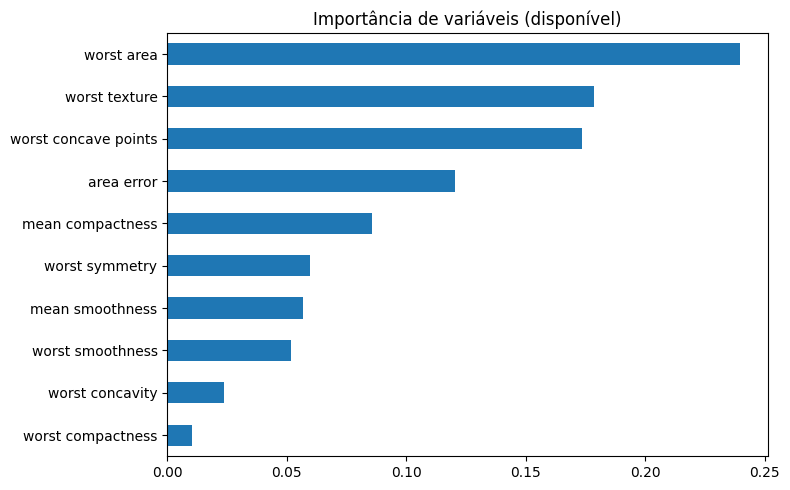

In [16]:
# === Bloco 9: Sele√ß√£o do melhor por CV e avalia√ß√£o em teste ===
import numpy as np
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

# 1) Selecionar o melhor pipeline pela m√©dia de CV
best_name, best_mean = None, -np.inf
for name, scores in cv_scores.items():
    if scores.mean() > best_mean:
        best_mean = scores.mean()
        best_name = name

best_pipe = pipelines[best_name]
print(f"Melhor pipeline por CV: {best_name} | m√©dia={best_mean:.4f}")

# 2) Treinar no conjunto de treino completo
best_pipe.fit(X_train, y_train)

# 3) Avalia√ß√£o no conjunto de teste
y_pred  = best_pipe.predict(X_test)
y_proba = best_pipe.predict_proba(X_test)[:, 1] if hasattr(best_pipe, "predict_proba") else None

# Nomes em PT-BR para o relat√≥rio e matriz de confus√£o
labels_pt = ["Maligno", "Benigno"]

print("\nM√©tricas (teste):")
print(classification_report(y_test, y_pred, target_names=labels_pt, digits=4))

ConfusionMatrixDisplay.from_estimator(
    best_pipe, X_test, y_test, display_labels=labels_pt
)
plt.title("Matriz de confus√£o ‚Äî Melhor modelo (teste)")
plt.tight_layout()
plt.show()

# 4) Import√¢ncia de vari√°veis (se o modelo suportar)
modelo_final = best_pipe.named_steps.get("modelo")
if hasattr(modelo_final, "feature_importances_"):
    # pega as colunas que o pr√©-processador realmente enviou ao modelo
    pre = best_pipe.named_steps.get("pre")
    cols_usadas = None
    if hasattr(pre, "transformers_"):
        for name, trans, cols in pre.transformers_:
            if name == "num":
                cols_usadas = list(cols)
                break
    if cols_usadas is None:
        cols_usadas = final_num_cols if "final_num_cols" in locals() else X_train.columns.tolist()

    importances = modelo_final.feature_importances_
    # garante que o tamanho bata
    k = min(len(importances), len(cols_usadas))
    imp_ser = pd.Series(importances[:k], index=cols_usadas[:k]).sort_values(ascending=False)

    print("\nTop 15 import√¢ncias (dispon√≠vel):")
    display(imp_ser.head(15))
    ax = imp_ser.head(15).plot(kind="barh", figsize=(8, 5))
    ax.invert_yaxis()
    plt.title("Import√¢ncia de vari√°veis (dispon√≠vel)")
    plt.tight_layout()
    plt.show()


## 10. Refit com todo o dataset e salvando artefatos

In [18]:
# === Bloco 10: Refit com todo o dataset e salvando artefatos ===
from joblib import dump           # <-- necess√°rio para salvar o pipeline
import json
from datetime import datetime

# 1) Refit do melhor pipeline no dataset COMPLETO (X, y)
best_pipe.fit(X, y)

# 2) Descobrir as colunas efetivamente usadas pelo pr√©-processador (sem data leakage)
pre = best_pipe.named_steps.get("pre")
features_usadas = None
if hasattr(pre, "transformers_"):
    for name, trans, cols in pre.transformers_:
        if name == "num":
            features_usadas = list(cols)
            break
if features_usadas is None:
    # fallback: usa vari√°veis finais definidas antes; se n√£o houver, usa X.columns
    features_usadas = final_num_cols if "final_num_cols" in locals() else X.columns.tolist()

# 3) Caminhos de sa√≠da
model_path = "breast_cancer_best_pipeline.joblib"
meta_path  = "breast_cancer_metadata.json"

# 4) Salvar o pipeline
dump(best_pipe, model_path)

# 5) Salvar metadados (√∫til para produ√ß√£o/servir)
labels_pt = ["Maligno", "Benigno"]
meta = {
    "created_at_utc": datetime.utcnow().isoformat() + "Z",
    "labels": labels_pt,
    "n_features": len(features_usadas),
    "features": features_usadas,
    "chosen_model": type(best_pipe.named_steps["modelo"]).__name__,
    "pipeline_steps": list(best_pipe.named_steps.keys())
}
with open(meta_path, "w", encoding="utf-8") as f:
    json.dump(meta, f, ensure_ascii=False, indent=2)

print(f"‚úî Pipeline salvo em: {model_path}")
print(f"‚úî Metadados salvos em: {meta_path} (sem data leakage)")


‚úî Pipeline salvo em: breast_cancer_best_pipeline.joblib
‚úî Metadados salvos em: breast_cancer_metadata.json (sem data leakage)


## 11. Predi√ß√£o em novos dados

In [19]:
# === Bloco 11: Predi√ß√£o em novos dados ===
# Reutiliza: best_pipe j√° treinado no Bloco 10

import joblib  # <-- garante o load aqui

# 1) Exemplo did√°tico de "novos dados"
novos = X.sample(3, random_state=SEED).reset_index(drop=True)

# 2) Predi√ß√£o com o pipeline em mem√≥ria (treinado no Bloco 10)
pred = best_pipe.predict(novos)

# Probabilidade (se houver)
proba_pos = None
if hasattr(best_pipe, "predict_proba"):
    probas = best_pipe.predict_proba(novos)
    idx_pos = list(best_pipe.classes_).index(1) if 1 in best_pipe.classes_ else 1
    proba_pos = probas[:, idx_pos]

# 3) Sa√≠da amig√°vel
map_pt = {0: "Maligno", 1: "Benigno"}
saida = novos.copy()
saida["predi√ß√£o"] = [map_pt[int(v)] for v in pred]
if proba_pos is not None:
    saida["prob_benigno"] = proba_pos.round(4)

print("‚ñ∂ Predi√ß√µes em novos dados:")
display(saida)

# 4) (Opcional) Checagem de carga do artefato salvo no Bloco 10
#    (se mudar o nome/caminho no Bloco 10, ajuste aqui tamb√©m)
artefato = "breast_cancer_best_pipeline.joblib"
loaded_pipe = joblib.load(artefato)  # <-- usa joblib.load, n√£o 'load'

demo_preds = loaded_pipe.predict(novos.head(1))
print("\nChecagem de carga do artefato:")
print(f"  Predi√ß√£o para 1 amostra: {map_pt[int(demo_preds[0])]}")


‚ñ∂ Predi√ß√µes em novos dados:


mean radius  mean texture  mean perimeter  mean area  mean smoothness  mean compactness  mean concavity  mean concave points  mean symmetry  mean fractal dimension  radius error  texture error  perimeter error  area error  smoothness error  compactness error  concavity error  concave points error  symmetry error  fractal dimension error  worst radius  worst texture  worst perimeter  worst area  worst smoothness  worst compactness  worst concavity  worst concave points  worst symmetry  worst fractal dimension predi√ß√£o  prob_benigno
0        12.47         18.60           81.09      481.9          0.09965            0.1058         0.08005              0.03821         0.1925                 0.06373        0.3961         1.0440            2.497       30.29          0.006953            0.01911          0.02701               0.01037         0.01782                 0.003586         14.97          24.64            96.05       677.9            0.1426             0.2378           0.2671                0.1015          0.3014                  0.08750  Benigno        0.5687
1        18.94         21.31          123.60     1130.0          0.09009            0.1029         0.10800              0.07951         0.1582                 0.05461        0.7888         0.7975            5.486       96.05          0.004444            0.01652          0.02269               0.01370         0.01386                 0.001698         24.86          26.58           165.90      1866.0            0.1193             0.2336           0.2687                0.1789          0.2551                  0.06589  Maligno        0.2690
2        15.46         19.48          101.70      748.9          0.10920            0.1223         0.14660              0.08087         0.1931                 0.05796        0.4743         0.7859            3.094       48.31          0.006240            0.01484          0.02813               0.01093         0.01397                 0.002461         19.26          26.00           124.90      1156.0            0.1546             0.2394           0.3791                0.1514          0.2837                  0.08019  Maligno        0.2688


Checagem de carga do artefato:
  Predi√ß√£o para 1 amostra: Benigno
